In [34]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary
from torch.autograd import Variable

https://disassemble-channel.com/lstm-multivariate-time-series/  
に対して株価を予測させたやつ

In [35]:
df = pd.read_csv("https://raw.githubusercontent.com/aweglteo/tokyo_weather_data/main/data.csv", parse_dates=True, index_col=0)
df = pd.read_csv('./lstm_temp.csv')
df

,Date,AACI,AADI,AAL,AAME
0,2022-10-27,9.980,12.700,13.97,3.016111
1,2022-10-28,9.980,12.950,14.00,2.956778
2,2022-10-31,9.960,12.915,14.18,2.838111
3,2022-11-01,9.965,12.880,14.11,2.808444
4,2022-11-02,9.965,12.440,13.58,2.966667
...,...,...,...,...,...
246,2023-10-20,10.690,4.090,11.08,1.810000
247,2023-10-23,10.690,3.940,11.29,1.940000
248,2023-10-24,10.690,4.290,11.21,1.940000
249,2023-10-25,10.690,4.220,11.04,1.800000


In [36]:
columns

['AACI', 'AADI', 'AAL', 'AAME']

In [37]:
columns = list(df.columns)
columns.pop(0)

'Date'

In [38]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[columns])
df_scaled

array([[0.02409579, 0.89754098, 0.37757739, 0.97777778],
       [0.02409579, 0.92315574, 0.38144334, 0.93333351],
       [0.        , 0.91956969, 0.40463926, 0.84444444],
       ...,
       [0.8795176 , 0.03586065, 0.02190723, 0.17170212],
       [0.8795176 , 0.0286885 , 0.        , 0.06683311],
       [0.86747028, 0.03483608, 0.01417521, 0.12346236]])

In [39]:
# テスト用と訓練用で分割
df_train, df_test = train_test_split(df_scaled, test_size=0.3, shuffle=False)

window_size = 20
n_data = len(df) - window_size + 1 -1

n_dim = df_train.shape[1]
n_train = len(df_train) - window_size + 1 - 1
n_test = len(df_test) - window_size + 1 - 1

# 正解データを準備
train = np.zeros((n_train, window_size, n_dim))
train_labels = np.zeros((n_train, n_dim))
for i in range(n_train):
    train[i] = df_train[i:i+window_size]
    train_labels[i] = df_train[i+window_size]

# テストデータを準備
test = np.zeros((n_test, window_size, n_dim))
test_labels = np.zeros((n_test, n_dim))
for i in range(n_test):
    test[i] = df_test[i:i+window_size]
    test_labels[i] = df_test[i+window_size]

# 訓練ラベルの用意。今回は平均気温を予測する
train_labels =train_labels[:, 2]

In [40]:
train = torch.tensor(train, dtype=torch.float)
labels = torch.tensor(train_labels, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(train, labels)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [41]:
# 多変量を入力して、１変数の予測結果を返すLSTNモデル.
class MyLSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_output = 1

        self.lstm = nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, self.n_output)

    def forward(self, x):
        h_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        c_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_dim) 
        y = self.fc(hn)
        y = y.reshape(self.n_output, -1)

        return y


feature_size  = 4
n_hidden  = 64
n_layers  = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = MyLSTM(feature_size, n_hidden, n_layers).to(device)

In [42]:
summary(net)

Layer (type:depth-idx)                   Param #
MyLSTM                                   --
├─LSTM: 1-1                              17,920
├─Linear: 1-2                            65
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0

In [43]:
func_loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_history = []

print(f"run with {device}")
epochs = 200

net.to(device)

run with cuda


MyLSTM(
  (lstm): LSTM(4, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [44]:
for i in range(epochs+1):
    net.train()
    tmp_loss = 0.0
    for j, (x, t) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        y = net(x).to('cpu')
        loss = func_loss(y, t)
        loss.backward()
        optimizer.step() 
        tmp_loss += loss.item()
    tmp_loss /= j+1
    loss_history.append(tmp_loss)
    print('Epoch:', i, 'Loss_Train:', tmp_loss)

C:\Users\drryu\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\drryu\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss_Train: 0.06850821988131756
Epoch: 1 Loss_Train: 0.019918264271930244
Epoch: 2 Loss_Train: 0.008791196706274955
Epoch: 3 Loss_Train: 0.007677561394535961
Epoch: 4 Loss_Train: 0.006937436654250353
Epoch: 5 Loss_Train: 0.0061383144422553675
Epoch: 6 Loss_Train: 0.006611913372464
Epoch: 7 Loss_Train: 0.005893157195084943
Epoch: 8 Loss_Train: 0.005233529578291405
Epoch: 9 Loss_Train: 0.005651253656161806
Epoch: 10 Loss_Train: 0.00614184231007806
Epoch: 11 Loss_Train: 0.004935362063593064
Epoch: 12 Loss_Train: 0.005256387773746003
Epoch: 13 Loss_Train: 0.004281441738921552
Epoch: 14 Loss_Train: 0.004106155932486917
Epoch: 15 Loss_Train: 0.004083057522970753
Epoch: 16 Loss_Train: 0.004045373765014422
Epoch: 17 Loss_Train: 0.004254115115588483
Epoch: 18 Loss_Train: 0.0037748581813409543
Epoch: 19 Loss_Train: 0.0035565442805632185
Epoch: 20 Loss_Train: 0.003378220596716393
Epoch: 21 Loss_Train: 0.0032437434263276653
Epoch: 22 Loss_Train: 0.0032138021268063965
Epoch: 23 Loss_Train:

In [33]:
torch.save(net.state_dict(), f'./lstm.pth')

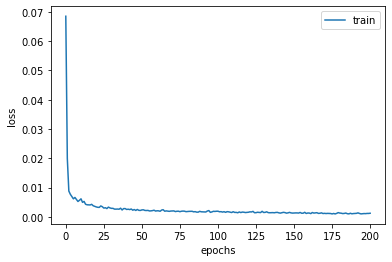

In [45]:
plt.plot(range(len(loss_history)), loss_history, label='train')
plt.legend()

plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [46]:
predicted_train_plot = []
net.eval()

for k in range(n_train):
    x = torch.tensor(train[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    predicted_train_plot.append(y[0].item())
    

C:\Users\drryu\AppData\Local\Temp\ipykernel_16708\1814804422.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train[k])


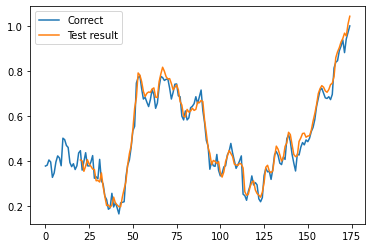

In [47]:

plt.plot(range(len(df_train)), df_train[:, 2], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_train_plot)), predicted_train_plot, label='Test result')
plt.legend()
plt.show()

In [48]:
predicted_test_plot = []
net.eval()

for k in range(n_test):
    x = torch.tensor(test[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    predicted_test_plot.append(y[0].item())

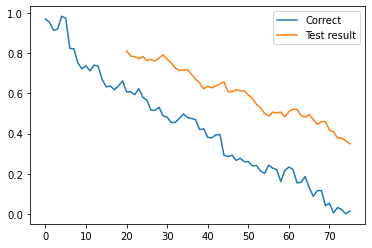

In [49]:
plt.plot(range(len(df_test)), df_test[:, 2], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_test_plot)), predicted_test_plot, label='Test result')
plt.legend()
plt.show()